# Search engine

Arguments to set: 

- search: string containing the search query
        
- pubdate_before: to get papers with publication dates before pubdate_before. format date : year-month-day
- pubdate_after: to get papers with publication dates after pubdate_before. format date : year-month-day
- pubdate_in: to get papers with publication dates between two dates. format date : year1-month1-day1 year2-month2-day2
- tags: string containing tag words
- topn: maximum number of results to be returned,
- topn_sent: maximum number of sentences closely linked to search in a given paper



To have an idea about what we are doing, here are some screenshots of what we get at the end of this notebook.

#### <center> Interactive search bar <center> 

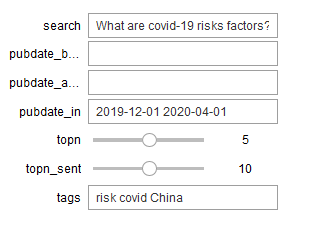

#### <center> Results <center> 

In [1]:
import pandas as pd
import numpy as np


import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import preprocess_string

from ipywidgets import interact
from IPython.display import display, HTML

from gensim.summarization.textcleaner import get_sentences

import re
from sklearn.metrics.pairwise import cosine_similarity
import time


In [2]:
def get_data(dir_path):
    
    """
    Take as input a directory path containing json files from 
    biorxiv_medrxiv, comm_use_subset, noncomm_use_subset or custom_license.
    Four dataframes are returned: papers_df, authors_df, affiliations_df, bib_entries_df
    """
    
    files = os.listdir(dir_path)
    papers_df = pd.DataFrame(columns= ["paper_id", "title", "authors", "abstract", "body_text", "bib_titles", "dataset"])
    authors_df = pd.DataFrame(columns= ["author", "affiliation"])
    affiliations_df = pd.DataFrame(columns= ["affiliation", "country"])
    bib_entries_df = pd.DataFrame(columns=["title", "authors", "year", "venue"])
    
    line_author_df = 0
    line_affiliations_df = 0
    line_bib_entries_df = 0
    
    
    
    for line,file in enumerate(files):
        
        #loading information
        n_files = len(files)
        if (line%300==0)or(line==n_files-1):
            print("Line", line, " ", round(100*line/n_files, 2),"%")
            
        file_path = os.path.join("../data/{}".format(dir),file)
    
        with open(file_path) as f:
            data = json.load(f)
        
        
        #Papers
        
        paper_id = data["paper_id"]
        
        title = data["metadata"]["title"]
        
        authors, affiliations, countries = "", "", ""
        for author in data["metadata"]["authors"]:
            first_last_name = author["first"] + " " + author["last"]
            authors = authors + " || " + first_last_name
            
            if author["affiliation"]=={}:
                affiliation = "NA"  #Non Available
                affiliations = affiliations + " || " + affiliation.strip()
                
                country = "NA"
                countries = countries + " || " + country.strip()
                continue
                
            affiliation = author["affiliation"]["laboratory"] + " " + author["affiliation"]["institution"]
            affiliations = affiliations + " || " + affiliation.strip()
            
            if "country" not in author["affiliation"]["location"].keys():
                country = "NA"
                countries = countries + " || " + country
                continue
            
            country = author["affiliation"]["location"]["country"]
            countries = countries + " || " + country
            
        authors = authors[4:]   #extracting out the first separator " || name1 || name2" => "name1 || name2"
        affiliations = affiliations[4:]
        countries = countries[4:]
        
        abstract = ""
        for info in data["abstract"]:
            abstract = abstract + " " + info["text"]
        abstract = abstract.strip()

        body_text = ""
        for info in data["body_text"]:
            body_text = body_text + " " + info["text"]
        body_text = body_text.strip()

        bib_titles, bib_authors, years, venues = "", "", "", ""
        for bib in data["bib_entries"]:
            bib_titles = bib_titles + " || " + data["bib_entries"][bib]["title"]
            
            
            year = data["bib_entries"][bib]["year"]
            
            years = years + " || " + str(year)
            
            venue = data["bib_entries"][bib]["venue"]
            venues = venues + " || " + venue
   
            bib_author = [author["first"] + " " + author["last"] for author in data["bib_entries"][bib]["authors"]]
            bib_author = " | ".join(bib_author)
            bib_authors = bib_authors + " || " + bib_author
            
        bib_titles, bib_authors, years, venues = bib_titles[4:] , bib_authors[4:], years[4:], venues[4:] 
        
        ##appending to paper_df
        papers_df.loc[line, :] = [paper_id, title, authors, abstract, body_text, bib_titles, dir]
        
        
        #Authors
        authors_list = authors.split(" || ")
        affiliations_list = affiliations.split(" || ")
        
        for i in range(len(authors_list)):
            authors_df.loc[line_author_df, :] = authors_list[i],  affiliations_list[i]
            
            line_author_df+=1
        
        #Affiliations
        countries_list = countries.split(" || ")
        
        for i in range(len(affiliations_list)):
            affiliations_df.loc[line_affiliations_df,:] = affiliations_list[i], countries_list[i]
            
            line_affiliations_df+=1
        
        
        #Bibliograpphy
        bib_titles_list = bib_titles.split(" || ")
        bib_authors_list = bib_authors.split(" || ")
        years_list = years.split(" || ")
        venues_list = venues.split(" || ")
        
        
        for i in range(len(bib_titles_list)):
            
            bib_entries_df.loc[line_bib_entries_df, :] = bib_titles_list[i], bib_authors_list[i], years_list[i], venues_list[i]
            line_bib_entries_df+=1
            
    authors_df = authors_df.drop_duplicates().reset_index(drop=True)
    affiliations_df = affiliations_df.drop_duplicates().reset_index(drop=True)
    bib_entries_df = bib_entries_df.drop_duplicates().reset_index(drop=True)
    
    return papers_df, authors_df, affiliations_df, bib_entries_df

In [3]:
df = pd.read_csv("/kaggle/input/papers/papers.csv", sep=";", nrows=100)
df.head()

,paper_id,title,authors,abstract,body_text,bib_titles,dataset
0,0015023cc06b5362d332b3baf348d11567ca2fbb,The RNA pseudoknots in foot-and-mouth disease ...,Joseph Ward || Lidia Lasecka-Dykes || Chris Ne...,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",Genetic economy in 598 picornaviruses: Foot-an...,../data/unstructured/biorxiv_medrxiv
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,Healthcare-resource-adjusted vulnerabilities t...,Hanchu Zhou || Jiannan Yang || Kaicheng Tang |...,NaN,The 2019-nCoV epidemic has spread across China...,World Health Organizations. Novel Coronavirus ...,../data/unstructured/biorxiv_medrxiv
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,"Real-time, MinION-based, amplicon sequencing f...",Salman Butt || Eric Erwood || Jian Zhang || Ho...,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Emergence of novel strains of avian infectious...,../data/unstructured/biorxiv_medrxiv
3,0139ea4ca580af99b602c6435368e7fdbefacb03,A Combined Evidence Approach to Prioritize Nip...,Nishi Kumari || Ayush Upadhyay || Kishan Kalia...,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Molecular biology of Hendra and Nipah viruses ...,../data/unstructured/biorxiv_medrxiv
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Assessing spread risk of Wuhan novel coronavir...,Shengjie Lai || Isaac Bogoch || Nick Ruktanonc...,Background: A novel coronavirus (2019-nCoV) em...,"In December 2019, a cluster of patients with p...",A Novel Coronavirus Genome Identified in a Clu...,../data/unstructured/biorxiv_medrxiv


In [4]:
#dropping eventual duplicates
df = df.drop_duplicates()
df.shape

(100, 7)

In [5]:
meta_df = pd.read_csv("../input/CORD-19-research-challenge/metadata.csv")
meta_df.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998.0,unk,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125340?pdf=re...
1,ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704.0,unk,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125375?pdf=re...
2,wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125.0,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,2sfqsfm1,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,Structure of coronavirus main proteinase revea...,10.1093/emboj/cdf327,PMC126080,12093723.0,unk,The key enzyme in coronavirus polyprotein proc...,2002-07-01,"Anand, Kanchan; Palm, Gottfried J.; Mesters, J...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc126080?pdf=re...
4,i0zym7iq,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,Discontinuous and non-discontinuous subgenomic...,10.1093/emboj/cdf635,PMC136939,12456663.0,unk,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,"van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc136939?pdf=re...


In [6]:
#dropping any paper not present in the meta dataset. NB: paper_id (df) == sha (meta_df)
paper_in_meta = df.paper_id.isin(meta_df.sha)
df = df[paper_in_meta]
df = df.sort_values(by="paper_id", axis=0).reset_index(drop=True)

#Keeping meta data of papers present in the papers dataframe and sorting it acording to sha
meta_df = meta_df.loc[meta_df.sha.isin(df.paper_id.values)]
meta_df = meta_df.sort_values(by="sha", axis=0).reset_index(drop=True)

#We can now transfert information from meta to papers dataframe: both dataframe share now the same number of papers order in the same way
df["title"] = meta_df["title"]
df["abstract"] = meta_df["abstract"]
df["authors"] = meta_df["authors"]
df["publish_time"] = meta_df["publish_time"]
df["url"] = meta_df["url"]


In [7]:
df = df.loc[(df.title.notna()&df.authors.notna()&df.abstract.notna()), :].reset_index(drop=True)

df["paper"] = df.title + " " + df.abstract + " " + df.body_text


In [8]:

df["paper_token"] = df.paper.apply(preprocess_string)

In [9]:
n_papers = df.shape[0]
df["paper_tag"] = [TaggedDocument(words=df.paper_token[i],tags=[i]) for i in range(n_papers)]

In [10]:
model_doc2vec = Doc2Vec(df.paper_tag.values, dm=1, vector_size=200, window=5, min_count=1, workers=8, epochs=5)

In [11]:
def TagInText(text, tag_list):
    tagIn = False
    for tag in tag_list:
        match = re.match(".* {}.*|.* {}.*|.* {}.*".format(tag.lower(), tag.upper(), tag.capitalize()), text)
        if match:
            tagIn=True
    
    return tagIn

In [12]:
model_word2vec = Word2Vec(sentences=df.paper_token, size=100,window=5,min_count=1, seed=1,  sg =0)

#model_word2vec.save("../data/embedding/final/word2vec_cbow.model")

In [13]:

def SimilarWords(tags):
    tag_list = preprocess_string(tags)
    similar_words_list = []
    for tag in tag_list:
        #try is important here to avoid errors if a word is not in the vocabulary
        try:
            similar_words = model_word2vec.wv.most_similar(tag.lower())
            similar_words = [word_sim[0] for word_sim in similar_words]
            similar_words_list = similar_words_list + similar_words
        except:
            pass
    
    return list(set(similar_words_list)) #using set allows to filter out duplicates



In [14]:
#example of words closed to China
tags = "China Wuhan"
SimilarWords(tags)

['januari',
 'risk',
 'spread',
 'februari',
 'china',
 'provinc',
 'decemb',
 'citi',
 'outbreak',
 'outsid',
 'mainland',
 'wuhan']

In [15]:

def SearchIndex(search, data, column, model_doc2vec, pubdate_before=None, pubdate_after=None, pubdate_in=None, tags=None, topn=10, seed=0):
    
    """
    Take a search string and return list of line indexes of n closest papers
    
    search: string containing the query
    data: papers dataframe in the right format
    column: column in "data" containing papers texts
    model_doc2vec: a Doc2Vec model trained on papers from "data"
    pubdate_before: to get papers which publication dates are before "pubdate_before"; format date : year-month-day
    pubdate_after: to get papers which publication dates are after pubdate_before. format date : year-month-day
    pubdate_in: to get papers which publication dates are between date1 and date2. format date : year1-month1-day1 year2-month2-day2
    tags: string with tag words
    topn: maximum number of results to be returned,
    seed: an integer for random seed; useful for the doc2vec model. 
    """
    
    #filtering according to date
    if pubdate_before:
        data = data[data.publish_time<pubdate_before]
    if pubdate_after:
        data = data[data.publish_time>pubdate_after]
    if pubdate_in:
        date1 = pubdate_in.split()[0]
        date2 = pubdate_in.split()[1]
        data = data[(data.publish_time>=date1)&(data.publish_time<=date2)]
        
    n = data.shape[0]
    model_doc2vec.random.seed(seed)
    search = preprocess_string(search)
    search_vec = model_doc2vec.infer_vector(search)
    similar_text_index = model_doc2vec.docvecs.most_similar([search_vec], topn = n)
    similar_text_index = [index_sim[0] for index_sim in similar_text_index  if index_sim[0] in data.index]
    
    if tags: 
        tag_list = preprocess_string(tags)
        similar_words = SimilarWords(tags)
        tag_list = tag_list + similar_words
        
        filter_papers_index = []

        #finding articles containing tags
        tagged = data[column].apply(lambda paper: TagInText(paper,tag_list))
        tagged_papers_index = data[tagged].index
        
        similar_text_index = [index for index in similar_text_index if index in tagged_papers_index]

    
    similar_text_index = similar_text_index[:topn]

    
    
    return similar_text_index

In [16]:
search = "What is covid-19 risks factors?"
tags = "risk covid China"

select_indexes = SearchIndex(search=search, data=df, column="paper", model_doc2vec=model_doc2vec, pubdate_before="2020-02-01", topn=5)
select_indexes

[29, 6, 37, 24, 27]

In [17]:
sentences_df = pd.DataFrame(columns=["paper_index", "sentence"])

for paper_index in select_indexes:

    sentences_list = list(get_sentences(df.loc[paper_index, "body_text"]))
    n_sent = len(sentences_list)
    new_sent_df = pd.DataFrame(list(zip([paper_index]*n_sent, sentences_list)) , columns=["paper_index", "sentence"])
    sentences_df = sentences_df.append(new_sent_df)

sentences_df.head()

,paper_index,sentence
0,29,Protein-protein interactions are central to al...
1,29,Consequently the effects of changes in protein...
2,29,"Methods which measure, predict or optimise the..."
3,29,"[3] ), designing combinatorial protein librari..."
4,29,"[24] ), uncovering the effects of pathological..."


In [18]:
#filtering out non relevant sentences 

pattern = ".*doi.*|.*http.*|.*copyright.*|.*author.*|.*license.*|.*without permission.*|.*CC-BY-NC-ND.*|.*author.*|.*funder.*|.*medrxiv.*|.*fig.*|.*all rights.*"
sentences_df["filtered"] = sentences_df["sentence"].apply(lambda sent: True if re.match(pattern, sent.lower()) else False)

sentences_df = sentences_df.loc[~sentences_df.filtered,:]
sentences_df = sentences_df.reset_index(drop=True)

sentences_df.head()

sentences_df["sentence_token"] = sentences_df.sentence.apply(preprocess_string)

#### Filtering out sentences with less than 5 tokens

sentences_df.sentence_token = sentences_df.sentence_token.apply(lambda sent: sent if len(sent)>5 else np.nan)
sentences_df = sentences_df.dropna().reset_index(drop=True)



In [19]:
def RelevantSent(search, papers_indexes, topn_sent=5, tags=None):
    """
    This is a function that look for more relevant sentences in a list of papers given a search.
    It returns a dictionary which keys are papers indexes and values are list of top n relevant sentences
    """
    model_doc2vec.random.seed(1)
    search = preprocess_string(search)
    search_vec = model_doc2vec.infer_vector(search)

    sentences_df["sent_vec"] = sentences_df.sentence_token.apply(model_doc2vec.infer_vector).values
    sentences_df["cos_similarity"] = sentences_df.sent_vec.apply(lambda sent_vec: cosine_similarity(search_vec.reshape(-1,1), sent_vec.reshape(-1,1))[0][0])

    topn_sent_dict = {}
    
    if tags:
        tags = preprocess_string(tags) + SimilarWords(tags)
            
    for paper_index in papers_indexes:
        sent_paper_order = sentences_df.loc[sentences_df.paper_index==paper_index, :]
        sent_paper_order = sent_paper_order.sort_values(by="cos_similarity", axis=0, ascending=False).reset_index(drop=True)

        
        #keeping only sentences with at least one tag word
        sent_list_tag = []
        if tags:
            sent_list = list(sent_paper_order.loc[:1000, "sentence"])
            for sent in sent_list:
                tagIn = TagInText(sent, tags)
                if tagIn is True:
                    sent_list_tag.append(sent)

        else:
            sent_list_tag = list(sent_paper_order.loc[:topn_sent-1, "sentence"])
            
        topn_sent_dict[paper_index] = sent_list_tag[:topn_sent]
        
    return topn_sent_dict

In [20]:

top_sent = RelevantSent(search, select_indexes, topn_sent=10, tags=tags)
paper_index = select_indexes[0]
top_sent[paper_index]


['The range of ∆∆G int values rarely fall outside of the -5 to 3 kcal.mol −1 range.',
 'SKEMPI has also been used to study human disease [56] , [16] , [55] , assessing the role of dynamics on binding [69] , exploring the conservation of binding regions [28] , evaluating experimental affinity measurement methods [22] , as well serving as a data source for models which predict dissociation rate changes upon mutation [1] , pathological mutations [23] , hotspot residues (e.g.',
 'Consequently the effects of changes in protein sequence on the structure, thermodynamics and kinetics of protein-protein interactions has wide implications for constraining the permissible substitutions that accrue over the course of evolution, and for understanding the molecular etiology of disease.']

It is possible to not get any relevant sentence cause we only keep the ones that contain at least one tag or one similar word. 

#### Presenting results

In [21]:

def SearchDisplayPaper(search, model_doc2vec, pubdate_before=None, pubdate_after=None, pubdate_in=None, topn=10, topn_sent=10, tags=None):
    """
    Take a request and return most relevant papers, with their titles, authors, abstracts and most relevant sentences
    
    search: string containing the query
    model_doc2vec: a Doc2Vec model trained on papers from "data"
    pubdate_before: to get papers which publication dates are before "pubdate_before"; format date : year-month-day
    pubdate_after: to get papers which publication dates are after pubdate_before. format date : year-month-day
    pubdate_in: to get papers which publication dates are between date1 and date2. format date : year1-month1-day1 year2-month2-day2
    tags: string with tag words
    topn: maximum number of results to be returned,
    seed: an integer for random seed; useful for the doc2vec model. 
    """
    
    select_indexes = SearchIndex(search=search, data=df, column="paper", model_doc2vec=model_doc2vec, pubdate_before=pubdate_before, pubdate_after=pubdate_after, pubdate_in=pubdate_in, tags=tags, topn=topn)
    top_sent = RelevantSent(search, select_indexes, topn_sent=topn_sent, tags=tags)

    if tags:
        tag_list = tags.split()
        similar_words = SimilarWords(tags)
            
    summary = ""
    
    for i,index in enumerate(select_indexes):
        title, authors, date, url, abstract = list(df.loc[index, ["title", "authors", "publish_time", "url", "abstract"]])
        
        sentences = top_sent[index]
        top_sentences = [
                """
                <p>&nbsp;</p>
                <h3 style="text-align: justify;"><span style="color: #800080;"><strong>Sentence {nb}:</h3>
                <h4 style="text-align: justify;"></strong> <span style="color: #000000;">{sent}</span></span></h4>
                """.format(nb=i+1, sent=sent) for i, sent in enumerate(sentences) 
                ]

        top_sentences = " ".join(top_sentences)
        
        
        if tags:
            
            #highlighting tags in magenta
            for tag in similar_words:
                abstract = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff00ff;"> {}</span>""".format(tag.capitalize()), abstract)
                top_sentences = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff00ff;"> {}</span>""".format(tag.capitalize()), top_sentences)
            #highlighting tags in red
            
            for tag in tag_list:
                abstract = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff0000;"> {}</span>""".format(tag.capitalize()), abstract)
                top_sentences = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff0000;"> {}</span>""".format(tag.capitalize()), top_sentences)
             
            
        summary = summary + """
        <p>&nbsp;</p>
        <p>&nbsp;</p>
        <h1><span style="color: #333300; background-color: #ffffff;">Paper {nb}.</span></h1>
        <p>&nbsp;</p>
        <h1><span style="color: #800000; background-color: #999999;">Title:<span style="background-color: #ffffff;"> {title} </span></span></h1>
        <p>&nbsp;</p>
        <p><strong><span style="color: #800000; background-color: #999999;"><span style="background-color: #ffffff;">Authors: {authors} </span></span></strong></p>
        <p><span style="color: #003366;"><strong>Publication date: {date} </strong></span></p>
        <p><a href={url} ><span style="color: #3366ff;"><strong>Link to full paper</strong></span> </a></p>
        <p>&nbsp;</p>
        <h2><span style="background-color: #999999;">Abstract: </span></h2>
        <p>&nbsp;</p>
        <h4  style="text-align: justify;"><span style="background-color: #ffffff;"> {abstract} </span></h4>
        
        """.format(nb=i+1, title=title, authors=authors, date=date, url=url, abstract=abstract)
        
        
        summary = summary + top_sentences
        
    summary = HTML(summary)
    
    return display(summary)

In [22]:
SearchDisplayPaper(search, model_doc2vec=model_doc2vec, pubdate_before="2020-04-01", topn=10, topn_sent=5, tags=tags)

In [23]:
class Search():
    def __init__(self, papers_df, meta_df=None, papers_preprocessed=False, model_doc2vec=None, model_word2vec=None):
        """
         papers_df: papers dataframe in the right fromat
         meta_df: meta dataframe. if "papers_preprocessed=True", meta_df must be provided
         papers_preprocessed: True if papers need to be preprocessed, False otherwise
         model_doc2vec: A doc2vec model train on papers from "papers_df["paper"]"
         model_word2vec: A word3vec model preferably trained on "papers_df["paper"]"
        """
        
        if papers_preprocessed:
            self.papers_df = papers_df
            self.model_doc2vec = model_doc2vec 
            self.model_word2vec = model_word2vec
        else:   
            self.papers_df = self.preprocessing_papers(papers_df, meta_df)
        
             
        
            
        self.html_index = 0  #for html hidden links
        
    def preprocessing_papers(self, papers_df, meta_df):

        print("Processing papers!", time.strftime("%H:%M:%S", time.localtime()))

        
        print("Keeping only papers with meta data!", time.strftime("%H:%M:%S", time.localtime()))

        paper_in_meta = papers_df.paper_id.isin(meta_df.sha)
        papers_df = papers_df[paper_in_meta]
        papers_df = papers_df.sort_values(by="paper_id", axis=0).reset_index(drop=True)

        ##Keeping meta data of papers present in the papers dataframe and sorting it acording to sha/paper_id
        meta_df = meta_df.loc[meta_df.sha.isin(papers_df.paper_id.values)]
        meta_df = meta_df.sort_values(by="sha", axis=0).reset_index(drop=True)

        ##We can now transfert information from meta to papers dataframe
        papers_df["title"] = meta_df["title"]
        papers_df["abstract"] = meta_df["abstract"]
        papers_df["authors"] = meta_df["authors"]
        papers_df["publish_time"] = meta_df["publish_time"]
        papers_df["url"] = meta_df["url"]
        
        print("Concatenation of titles, abstracts and body_texts!", time.strftime("%H:%M:%S", time.localtime()))
        papers_df["paper"] = papers_df.title + " " + papers_df.abstract + " " + papers_df.body_text
        
        
        print("Dropping papers without title, authors names or abstract!", time.strftime("%H:%M:%S", time.localtime()))
        papers_df = papers_df.loc[(papers_df.title.notna()&papers_df.authors.notna()&papers_df.abstract.notna()), :].reset_index(drop=True)
        
        print("Tokenization!", time.strftime("%H:%M:%S", time.localtime()))
        papers_df["paper_token"] = papers_df.paper.apply(preprocess_string)
        

        print("Building a Doc2Vec model with preprocessed data", time.strftime("%H:%M:%S", time.localtime()))
        n_papers = papers_df.shape[0]
        papers_df["paper_tag"] = [TaggedDocument(words=papers_df.paper_token[i],tags=[i]) for i in range(n_papers)]
        model_doc2vec = Doc2Vec(papers_df.paper_tag.values, dm=1, vector_size=200, window=5, min_count=1, workers=8, epochs=5)
        self.model_doc2vec = model_doc2vec 
        
        print("Building a Word2Vec model with preprocessed data", time.strftime("%H:%M:%S", time.localtime()))
        model_word2vec = Word2Vec(sentences=papers_df.paper_token, size=100,window=5,min_count=1, seed=1,  sg =0)
        self.model_word2vec = model_word2vec 

        print("Processing over! Do not forget saving the preprocessed data (self.papers_df), the doc2vec and word2vec models (self.model_doc2vec and self.model_word2vec) to go faster next time")

        return papers_df
    
    
        
    def preprocessing_sentences(self, select_indexes):
        
        """
        Generating a dataframe with columns ["paper_index", "sentence"]: 
        each line with a given sentence and the paper_index of the paper containing the sentence
        """
        sentences_df = pd.DataFrame(columns=["paper_index", "sentence"])

        for paper_index in select_indexes:

            sentences_list = list(get_sentences(self.papers_df.loc[paper_index, "body_text"]))
            n_sent = len(sentences_list)
            new_sent_df = pd.DataFrame(list(zip([paper_index]*n_sent, sentences_list)) , columns=["paper_index", "sentence"])
            sentences_df = sentences_df.append(new_sent_df)

    
        #filtering out non relevant sentences 

        pattern = ".*doi.*|.*http.*|.*copyright.*|.*author.*|.*license.*|.*without permission.*|.*CC-BY-NC-ND.*|.*author.*|.*funder.*|.*medrxiv.*|.*fig.*|.*all rights.*"
        sentences_df["filtered"] = sentences_df["sentence"].apply(lambda sent: True if re.match(pattern, sent.lower()) else False)

        sentences_df = sentences_df.loc[~sentences_df.filtered,:]

        sentences_df["sentence_token"] = sentences_df.sentence.apply(preprocess_string)

        #### Filtering out sentences with less than 5 tokens

        sentences_df.sentence_token = sentences_df.sentence_token.apply(lambda sent: sent if len(sent)>5 else np.nan)
        sentences_df = sentences_df.dropna().reset_index(drop=True)
        
        return sentences_df
    
    
    def TagInText(self, text, tag_list):
        tagIn = False
        for tag in tag_list:
            match = re.match(".* {}.*|.* {}.*|.* {}.*".format(tag.lower(), tag.upper(), tag.capitalize()), text)
            if match:
                tagIn=True

        return tagIn
    
    def SimilarWords(self,tags):
        """
        Find 5 words similar to each tag. Return a list of words filtered out of duplicates.
        """
        tag_list = preprocess_string(tags)
        similar_words_list = []
        for tag in tag_list:
            #try is important here to avoid errors if a word is not in the vocabulary
            try:
                similar_words = model_word2vec.wv.most_similar(tag.lower())
                similar_words = [word_sim[0] for word_sim in similar_words]
                similar_words_list = similar_words_list + similar_words
            except:
                pass

        return list(set(similar_words_list)) #using set allows to filter out duplicates


    def RelevantSent(self, search, papers_indexes, topn_sent, tags=None):
        """
        This is a function that look for more relevant sentences in a list of papers given a search.
        It returns a dictionary which keys are papers indexes and values are list of top n relevant sentences
        """
        
        sentences_df = self.preprocessing_sentences(papers_indexes)
        model_doc2vec = self.model_doc2vec
        
        model_doc2vec.random.seed(1)
        search = preprocess_string(search)
        search_vec = model_doc2vec.infer_vector(search)

        sentences_df["sent_vec"] = sentences_df.sentence_token.apply(model_doc2vec.infer_vector).values
        sentences_df["cos_similarity"] = sentences_df.sent_vec.apply(lambda sent_vec: cosine_similarity(search_vec.reshape(-1,1), sent_vec.reshape(-1,1))[0][0])

        topn_sent_dict = {}
        
        if tags:
            tag_list = preprocess_string(tags) + self.similar_words #including similar words to tags
            
        for paper_index in papers_indexes:
            sent_paper_order = sentences_df.loc[sentences_df.paper_index==paper_index, :]
            sent_paper_order = sent_paper_order.sort_values(by="cos_similarity", axis=0, ascending=False).reset_index(drop=True)


            #keeping only sentences with at least one tag word
            sent_list_tag = []
            if tags:
                sent_list = list(sent_paper_order.loc[:1000, "sentence"])
                for sent in sent_list:
                    tagIn = self.TagInText(sent, tag_list)
                    if tagIn:
                        sent_list_tag.append(sent)

            else:
                sent_list_tag = list(sent_paper_order.loc[:topn_sent-1, "sentence"])

            topn_sent_dict[paper_index] = sent_list_tag[:topn_sent]
        

        return topn_sent_dict

        
    
    def SearchIndex(self, search, pubdate_before=None, pubdate_after=None, pubdate_in=None, tags=None, topn=10, seed=0):

        """
        Take a search string and return list of indexes of n closest papers

        search: string containing the query
        pubdate_before: to get papers which publication dates are before "pubdate_before"; format date : year-month-day
        pubdate_after: to get papers which publication dates are after pubdate_before. format date : year-month-day
        pubdate_in: to get papers which publication dates are between date1 and date2. format date : year1-month1-day1 year2-month2-day2
        tags: string with tag words
        topn: maximum number of results to be returned,
        seed: an integer for random seed; useful for the doc2vec model. 
        """
        data = self.papers_df
        model_doc2vec=self.model_doc2vec
        
        #filtering according to date
        if pubdate_before:
            data = data[data.publish_time<pubdate_before]
        if pubdate_after:
            data = data[data.publish_time>pubdate_after]
        if pubdate_in:
            date1 = pubdate_in.split()[0]
            date2 = pubdate_in.split()[1]
            data = data[(data.publish_time>=date1)&(data.publish_time<=date2)]
            
        #Ranging papers indexes according to their similarity to the search query
        n = data.shape[0]
        model_doc2vec.random.seed(seed)
        search = preprocess_string(search)
        search_vec = self.model_doc2vec.infer_vector(search)
        similar_text_index = self.model_doc2vec.docvecs.most_similar([search_vec], topn = n)
        similar_text_index = [index_sim[0] for index_sim in similar_text_index  if index_sim[0] in data.index]
        
        if tags:
            tag_list = tags.split()
            self.similar_words = self.SimilarWords(tags)
            tag_list = tag_list + self.similar_words
            
            filter_papers_index = []

            #finding articles containing tags
            
            tagged = data["paper"].apply(lambda paper: self.TagInText(paper,tag_list))
            tagged_papers_index = data[tagged].index

            similar_text_index = [index for index in similar_text_index if index in tagged_papers_index]

        similar_text_index = similar_text_index[:topn]

        return similar_text_index


    def SearchDisplayPaper(self, search, pubdate_before=None, pubdate_after=None, pubdate_in=None, topn=10, topn_sent=5, tags=None):
        """
        Take a request and return most relevant papers, with their titles, authors, abstracts and most relevant sentences

        search: string containing the request
        pubdate_before: Publication dates should be before pubdate_before. format date : year-month-day
        pubdate_after: Publication dates should be after pubdate_before. format date : year-month-day
        pubdate_in: Publication dates should be between pubdate_before. format date : year1-month1-day1 format date year2-month2-day2
        tags: string with tag words
        topn: maximum number of results to be returned,
        topn_sent: maximum number of sentences closely linked to search in a given paper
        seed: an integer for random seed
        """
        
         
        select_indexes = self.SearchIndex(search=search, pubdate_before=pubdate_before, pubdate_after=pubdate_after, pubdate_in=pubdate_in, tags=tags, topn=topn)
        top_sent = self.RelevantSent(search, select_indexes, topn_sent=topn_sent, tags=tags)

        
    
        summary = """
                <script>
                function visibilite(thingId)
                {
                var targetElement;
                targetElement = document.getElementById(thingId) ;
                if (targetElement.style.display == "none")
                {
                targetElement.style.display = "" ;
                } else {
                targetElement.style.display = "none" ;
                }
                }
                </script>
                </body>
                """
        if tags!=None:   
            tag_list = preprocess_string(tags)
            
        paper_df = self.papers_df
        
        for i,index in enumerate(select_indexes):
            title, authors, date, url, abstract, body_text = list(paper_df.loc[index, ["title", "authors", "publish_time", "url", "abstract", "body_text"]])
            sentences = top_sent[index]
            #adding relevant sentences from the paper
            top_sentences = [
                """
                <p>&nbsp;</p>
                <h3 style="text-align: justify;"><span style="color: #800080;"><strong>Sentence {nb}:</h3>
                <h4 style="text-align: justify;"></strong> <span style="color: #000000;">{sent}</span></span></h4>
                """.format(nb=i+1, sent=sent) for i, sent in enumerate(sentences) 
                ]

            top_sentences = " ".join(top_sentences)
            
            
            if tags!=None:
                
                #highlighting similar words to tags in magenta color
                for tag in self.similar_words:
                    abstract = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff00ff;"> {}</span>""".format(tag.capitalize()), abstract)
                    top_sentences = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff00ff;"> {}</span>""".format(tag.capitalize()), top_sentences)
                    body_text = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff00ff;"> {}</span>""".format(tag.capitalize()), body_text)
            
                #highlighting tags in red color
                for tag in tag_list:
                    abstract = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff0000;"> {}</span>""".format(tag.capitalize()), abstract)
                    top_sentences = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff0000;"> {}</span>""".format(tag.capitalize()), top_sentences)
                    body_text = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff0000;"> {}</span>""".format(tag.capitalize()), body_text)
                
                
            #adding paper's summary
            summary = summary + """
            <p>&nbsp;</p>
            <p>&nbsp;</p>
            <h1><span style="color: #333300; background-color: #ffffff;">Paper {nb}.</span></h1>
            <p>&nbsp;</p>
            <h1><span style="color: #000000";>Title:<span style="color: #000080;"> {title} </span></span></h1>
            <p>&nbsp;</p>
            <p><strong><span style="color: #800000; background-color: #999999;"><span style="background-color: #ffffff;">Authors: {authors} </span></span></strong></p>
            <p><span style="color: #003366;"><strong>Publication date: {date} </strong></span></p>
            <p><a href={url} ><span style="color: #3366ff;"><strong>Link to full paper</strong></span> </a></p>
            <p>&nbsp;</p>
            <h2>
                <a href="javascript:visibilite('divid1{html_id}');"><span style="background-color: ##ffffff;">Abstract</span></a>
                | <a href="javascript:visibilite('divid2{html_id}');"><span style="background-color: ##ffffff;">Relevant sentences</span></a> |
                | <a href="javascript:visibilite('divid3{html_id}');"><span style="background-color: ##ffffff;">Read paper</span></a> |          
            </h2>
            <p>&nbsp;</p>
            <div id="divid1{html_id}" style="display:none;"></p>
                <h4  style="text-align: justify;">{abstract}</strong></h4>
            </div>
            <div id="divid2{html_id}" style="display:none;"></p>
                <p  style="text-align: justify;">{top_sentences}</strong></p>
            </div>
            <div id="divid3{html_id}" style="display:none;"></p>
                <p  style="text-align: justify;">{body_text}</strong></p>
            </div>
            """.format(nb=i+1, html_id=self.html_index, title=title, authors=authors, date=date, url=url, abstract=abstract, top_sentences=top_sentences, body_text=body_text)
            
            self.html_index+=1 
            
            
            
        summary = HTML(summary)
    
        return display(summary)
    
    
    


In [24]:
papers_preprocessed_df = pd.read_pickle("../input/preprocessedcord-19/papers_preprocessed.pkl") 
meta_df = pd.read_csv("../input/CORD-19-research-challenge/metadata.csv")
model_doc2vec =  Doc2Vec.load("../input/preprocessedcord-19/doc2vec_model_tag_papers")
model_word2vec =  Word2Vec.load("../input/preprocessedcord-19/word2vec_cbow.model")

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
#papers are preprocessed 
papers_preprocessed_df.head()

,paper_id,title,authors,abstract,body_text,bib_titles,dataset,publish_time,url,paper,paper_token,paper_tag
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...,"Cornelissen, E.; Dewerchin, H.L.; Van Hamme, E...",Abstract Feline infectious peritonitis virus (...,Feline infectious peritonitis (FIP) is a fatal...,Using direct immunofluorescence to detect coro...,../data/unstructured/custom_license,2007-03-31,https://doi.org/10.1016/j.vetmic.2006.11.026,Absence of surface expression of feline infect...,"[absenc, surfac, express, felin, infecti, peri...","([absenc, surfac, express, felin, infecti, per..."
1,001259ae6d9bfa9376894f61aa6b6c5f18be2177,Microheterogeneity of S-glycoprotein of mouse ...,"Oleszak, Emilia L.; Knisley, Keith; Rodkey, L....",Abstract Mouse hepatitis virus (MHV) strain JH...,(Accepted 10 January 1992) is a neurotropic co...,Selection of a single antibody-forming cell cl...,../data/unstructured/custom_license,1992-07-31,https://doi.org/10.1016/0166-0934(92)90173-b,Microheterogeneity of S-glycoprotein of mouse ...,"[microheterogen, glycoprotein, mous, hepat, vi...","([microheterogen, glycoprotein, mous, hepat, v..."
2,00142f93c18b07350be89e96372d240372437ed9,Immunity to Pathogens Taught by Specialized Hu...,"Geginat, Jens; Nizzoli, Giulia; Paroni, Moira;...",Dendritic cells (DCs) are specialized antigen-...,iNTRODUCTiON Human beings are constantly expos...,The dendritic cell system and its role in immu...,../data/unstructured/comm_use_subset,2015-10-13,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,Immunity to Pathogens Taught by Specialized Hu...,"[immun, pathogen, taught, special, human, dend...","([immun, pathogen, taught, special, human, den..."
3,0015023cc06b5362d332b3baf348d11567ca2fbb,The RNA pseudoknots in foot-and-mouth disease ...,Joseph C. Ward; Lidia Lasecka-Dykes; Chris Nei...,AbstractThe positive stranded RNA genomes of p...,"VP3, and VP0 (which is further processed to VP...",Genetic economy in 598 picornaviruses: Foot-an...,../data/unstructured/biorxiv_medrxiv,2020-01-11,https://doi.org/10.1101/2020.01.10.901801,The RNA pseudoknots in foot-and-mouth disease ...,"[rna, pseudoknot, foot, mouth, diseas, viru, d...","([rna, pseudoknot, foot, mouth, diseas, viru, ..."
4,0016983545c217458b711d5aaad5fba583d81171,Enhancement of feline infectious peritonitis v...,"Hohdatsu, Tsutomu; Tatekawa, Takahiro; Koyama,...",Abstract The effects of centrifugation on the ...,"Feline infectious peritonitis virus (FIPV), fa...",Characterization of monoclonal antibodies agai...,../data/unstructured/custom_license,1995-02-28,https://doi.org/10.1016/0166-0934(94)00119-2,Enhancement of feline infectious peritonitis v...,"[enhanc, felin, infecti, periton, viru, type, ...","([enhanc, felin, infecti, periton, viru, type,..."


In [26]:
%%time
searching = Search(papers_df=papers_preprocessed_df, papers_preprocessed=True,
                   model_doc2vec = model_doc2vec)


CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 14.5 µs


In [27]:
search_risk = "What are covid-19 risk factors?"
tags_risk = """risk smoking pulmonary disease co-infection respiratory viral infection 
transmissible virulent co-morbidities co-morbidity Neonate pregnant Socio-economic behavior economic impact"""

searching.SearchDisplayPaper(search=search_risk, pubdate_in="2019-12-01 2020-04-01", topn=5, topn_sent=10, tags=tags_risk)

In [28]:
search_transmission = """"Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors"""
tags_transmission = """transmission dynamics reproductive incubation serial interval environmental"""

searching.SearchDisplayPaper(search=search_transmission,  pubdate_in="2019-12-01 2020-04-01", topn=5,  topn_sent=10, tags=tags_transmission)

In [29]:
search_severity = """Severity of disease including risk of fatality 
among symptomatic hospitalized patients and high-risk patient groups about covid-19"""

tags_severity  = """severity disease fatality symptomatic hospitalized high-risk"""

searching.SearchDisplayPaper(search=search_severity, pubdate_in="2019-12-01 2020-04-01", topn=5, topn_sent=10, tags=tags_severity)

In [30]:
search_susceptibility = """Susceptibility of populations"""

tags_susceptibility  = """susceptibility population"""

searching.SearchDisplayPaper(search=search_susceptibility, pubdate_in="2019-12-01 2020-04-01", topn=5, topn_sent=10, tags=tags_susceptibility)

In [31]:
search_mitigation = """Public health mitigation measures"""

tags_mitigation  = """public health mitigation measures government"""

searching.SearchDisplayPaper(search=search_mitigation, pubdate_in="2019-12-01 2020-04-01", topn=5, topn_sent=10, tags=tags_mitigation)

In [32]:
interact(searching.SearchDisplayPaper, search="What are covid-19 risks factors?", 
         pubdate_before="", pubdate_after="", pubdate_in="2019-12-01 2020-04-01",
         topn=5, topn_sent=10, tags="risk covid China")

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>